## Drifters and Cmems data Notebook

### Introduction
This notebook aims to analyze the velocity data from drifters within the tropical Atlantic Ocean. It involves visualizing drifter velocity data, interpolating CMEMS data onto drifter data, and comparing the velocities between drifters and CMEMS.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 127
  - link : https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/drifter_6hour_qc.html
  - Periode : period : 03-04-2023 to 05-07-2023

- CMEMS Data:
  - Source: Copernicus Marine
  - Collection Frequency: Every 12 hours
  - Data Product: SEALEVEL_GLO_PHY_L4_MY_008_047
  - link :  https://doi.org/10.48670/moi-00148
  - download data : ahttps://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/download
  - Periode : period : 03-04-2023 to 05-07-2023

### Tasks

#### 1. Visualization of Drifter Velocity Data
- Plot the Eastward (ve) and Northward (vn) velocity as a function of time for a selected drifter.

#### 2. Interpolation of CMEMS Data on Drifter Data
- Interpolate CMEMS data onto the time series of the selected drifter data.

#### 3. Comparison between Drifter Velocities and Interpolated CMEMS Velocities
- Visualize the correlation and regression between drifter velocities (ve, vn) and interpolated CMEMS between the two datasets.
- Plot time series of both drifter velocities and interpolated CMEMS velocities.
- df[9540:9912]

## Import Library


In [55]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

from scipy.signal import hann, convolve

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation
from scipy.stats import linregress
from scipy.stats import pearsonr

## Read Drifter Data


In [56]:
fn='./drifter_6hour_qc_dc77_616f_005e_U1720625851189.nc';
ds=xr.open_dataset(fn);
ds

<xarray.Dataset>
Dimensions:    (row: 26473)
Dimensions without coordinates: row
Data variables:
    ID         (row) object ...
    time       (row) datetime64[ns] ...
    latitude   (row) float64 ...
    longitude  (row) float64 ...
    sst        (row) float64 ...
    ve         (row) float64 ...
    vn         (row) float64 ...
Attributes: (12/54)
    acknowledgement:            Lumpkin, Rick; Centurioni, Luca (2019). Globa...
    cdm_data_type:              Trajectory
    cdm_trajectory_variables:   ID
    comment:                    Global Drifter Program 6h data
    contributor_name:           NOAA Global Drifter Program
    contributor_role:           Data Acquisition Center
    ...                         ...
    summary:                    Global Drifter Program 6-hourly drifting buoy...
    time_coverage_end:          2023-07-05T00:00:00Z
    time_coverage_start:        2023-04-03T00:00:00Z
    title:                      Global Drifter Program - 6 Hour Interpolated ...
    Westernmost_Easting:        -70.0
    wmo_platform_code:          1300615

## Extract Coordinates and Variables


In [57]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data


In [58]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)
df

,longitude,latitude,time,ve,vn,sst
0,-20.944,-18.263,2023-04-03 00:00:00,-0.04675,-0.03786,26.529
1,-20.948,-18.261,2023-04-03 06:00:00,-0.02040,0.04809,26.483
2,-20.952,-18.245,2023-04-03 12:00:00,-0.08261,0.09331,26.550
3,-20.982,-18.225,2023-04-03 18:00:00,-0.12830,0.04969,26.644
4,-21.004,-18.225,2023-04-04 00:00:00,-0.12047,-0.00368,26.533
...,...,...,...,...,...,...
26468,-22.006,-19.946,2023-06-11 12:00:00,-0.03853,-0.05076,25.189
26469,-22.013,-19.961,2023-06-11 18:00:00,-0.05150,-0.06262,25.179
26470,-22.027,-19.971,2023-06-12 00:00:00,-0.06030,-0.04773,25.133
26471,-22.038,-19.980,2023-06-12 06:00:00,-0.06036,-0.05688,25.093


## Selecting Drifter Data


In [59]:
# Test: Our selected drifter has 372 observations.  

df_1 = df[20863:21235]
df_1

,longitude,latitude,time,ve,vn,sst
20863,-22.437,9.085,2023-04-03 00:00:00,-0.05437,-0.08116,27.393
20864,-22.436,9.064,2023-04-03 06:00:00,-0.04568,-0.09848,27.063
20865,-22.455,9.047,2023-04-03 12:00:00,-0.06759,-0.11388,26.890
20866,-22.462,9.020,2023-04-03 18:00:00,-0.07858,-0.08702,27.197
20867,-22.485,9.013,2023-04-04 00:00:00,-0.04339,-0.05212,27.486
...,...,...,...,...,...,...
21230,-22.268,11.538,2023-07-03 18:00:00,-0.01932,-0.05911,29.014
21231,-22.277,11.506,2023-07-04 00:00:00,-0.09729,-0.12572,29.063
21232,-22.307,11.489,2023-07-04 06:00:00,-0.16125,-0.04535,28.997
21233,-22.341,11.489,2023-07-04 12:00:00,-0.15302,0.09805,28.920


# Arrange to begin with index 0

In [60]:
ve_curr_2 = df_1.ve.values
vn_curr_2 = df_1.vn.values
sst_2 = df_1.sst.values
lon_2 = df_1.longitude.values
lat_2 = df_1.latitude.values
time_2 = df_1.time.values

In [61]:
data = {
    'longitude': lon_2,
    'latitude' : lat_2,
    'time'     : time_2,
    've'       : ve_curr_2,
    'vn'       : vn_curr_2,
    'sst'      : sst_2
}

df_2 = pd.DataFrame(data)
df_2

,longitude,latitude,time,ve,vn,sst
0,-22.437,9.085,2023-04-03 00:00:00,-0.05437,-0.08116,27.393
1,-22.436,9.064,2023-04-03 06:00:00,-0.04568,-0.09848,27.063
2,-22.455,9.047,2023-04-03 12:00:00,-0.06759,-0.11388,26.890
3,-22.462,9.020,2023-04-03 18:00:00,-0.07858,-0.08702,27.197
4,-22.485,9.013,2023-04-04 00:00:00,-0.04339,-0.05212,27.486
...,...,...,...,...,...,...
367,-22.268,11.538,2023-07-03 18:00:00,-0.01932,-0.05911,29.014
368,-22.277,11.506,2023-07-04 00:00:00,-0.09729,-0.12572,29.063
369,-22.307,11.489,2023-07-04 06:00:00,-0.16125,-0.04535,28.997
370,-22.341,11.489,2023-07-04 12:00:00,-0.15302,0.09805,28.920


## Space evolution of Eastward (ve) and Northward (vn) Velocity 

## Case of ve

The drifter is moving mainly northward.


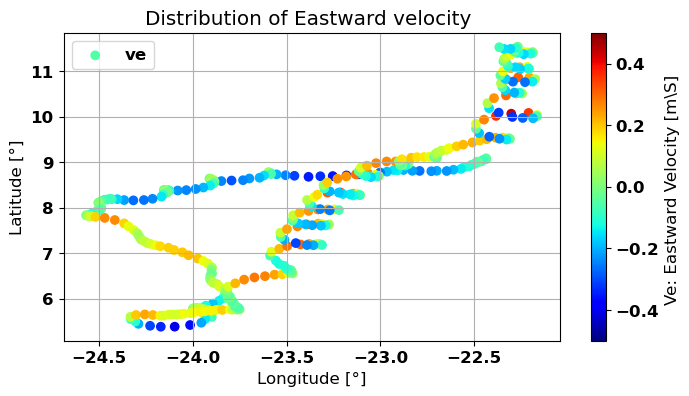

In [62]:
# Assuming you have a DataFrame named df with 'time' and 've' columns

# Plot ve as a function of time
plt.figure(figsize=(8, 4))
plt.scatter(df_2['longitude'], df_2['latitude'], c= df_2['ve'],vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and legend
plt.title('Distribution of Eastward velocity ')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='Ve: Eastward Velocity [m\S] ')

# Example of drifter trajectory data (latitude, longitude)
longitude = df_2['longitude']
latitude = df_2['latitude']

# Calculating position changes
delta_lat = np.diff(latitude)
delta_lon = np.diff(longitude)

# Determining the general direction of movement
if np.abs(delta_lat.sum()) > np.abs(delta_lon.sum()):
    if delta_lat.sum() > 0:
        direction = "northward"
    else:
        direction = "southward"
else:
    if delta_lon.sum() > 0:
        direction = "eastward"
    else:
        direction = "westward"

print(f"The drifter is moving mainly {direction}.")
        

plt.legend(['ve'])

# save graphe
plt.savefig("fig7 mode.png")
# Show plot
plt.show()

## Case of vn

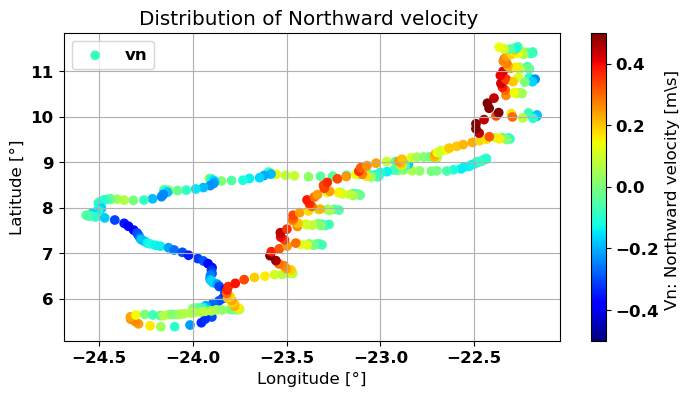

In [63]:
# Assuming you have a DataFrame named df with 'time' and 've' columns

# Plot ve as a function of time
plt.figure(figsize=(8, 4))
plt.scatter(df_2['longitude'], df_2['latitude'], c= df_2['vn'],vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and legend
plt.title('Distribution of Northward velocity ')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='Vn: Northward velocity [m\s] ')

plt.legend(['vn'])

# save graphe
plt.savefig("fig8 mode.png")
# Show plot
plt.show()

## Now let's interpolate the CMEMS data onto the grid of the drifter data.

### Case of Geostrophic Velocity Anomalies: Zonal Component (ugosa) 


- In this step, we interpolate the ugosa variable from the CMEMS data to the ve variable of the selected drifter.

- We utilize the linear interpolation method for this process. The interpolation is performed based on the variables of longitude, latitude, and important timestamps.

- This allows us to make comparisons and identify differences between drifter variables and CMEMS variables obtained through interpolations.

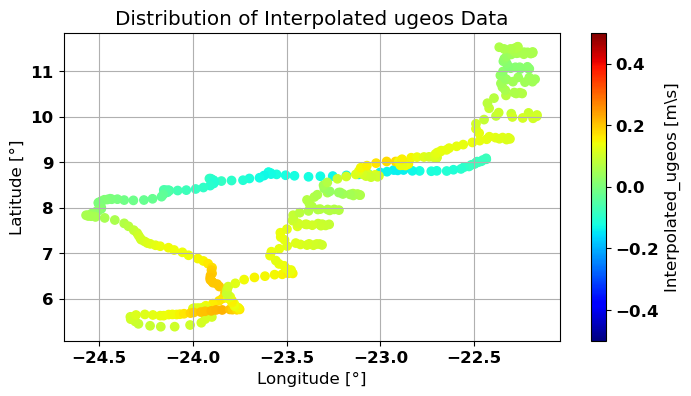

In [64]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df_2  
# Supposez que votre DataFrame contient des colonnes 'temps', 'latitude', 'longitude' et 've'

# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('cmems_obs_mob_glo_phy-cur_my_0.25deg_P1D-m_1720626101580.nc')   
# Supposez que vos données satellitaires sont stockées dans une variable appelée 'u_current'

# Extraction des données de courant des bouées
bouees_courant_u = df_bouees['ve']

# Extraction des données de courant satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_1 = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['ugos'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_1.append(courant)

# Plot the interpolated data
plt.figure(figsize=(8, 4))
plt.scatter(df_2['longitude'], df_2['latitude'], c= satellitaires_courant_1,vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and colorbar
plt.title('Distribution of Interpolated ugeos Data')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='Interpolated_ugeos [m\s]')

# save graphe
plt.savefig("fig9 mode.png")
# Show plot
plt.show()

### Case of Geostrophic Velocity Anomalies: Meridional Component (vgosa) 

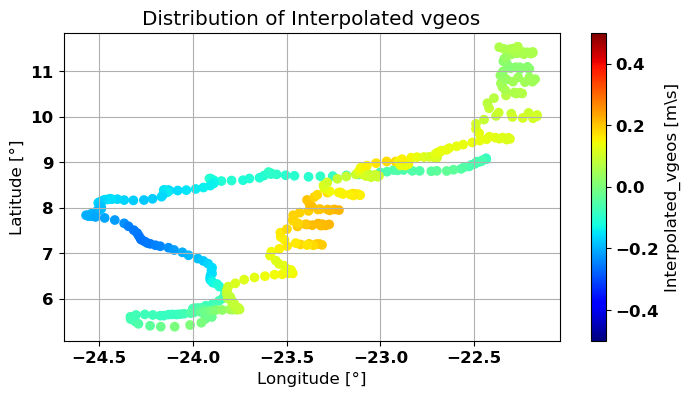

In [65]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df_2
# Supposez que votre DataFrame contient des colonnes 'temps', 'latitude', 'longitude' et 'vn'

# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('cmems_obs_mob_glo_phy-cur_my_0.25deg_P1D-m_1720626101580.nc')   
# Supposez que vos données satellitaires sont stockées dans une variable appelée 'u_current'

# Extraction des données de courant des bouées
bouees_courant_v = df_bouees['vn']

# Extraction des données de courant satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_2 = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['vgos'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_2.append(courant)

# Plot the interpolated data
plt.figure(figsize=(8, 4))
plt.scatter(df_2['longitude'], df_2['latitude'], c= satellitaires_courant_2,vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and colorbar
plt.title('Distribution of Interpolated vgeos')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='Interpolated_vgeos [m\s]')

# save graphe
plt.savefig("fig10 mode.png")
# Show plot
plt.show()

## Now Let's Compare Drifter Speeds and  CMEMS Speeds

## Comparison between ve and ugosa


## Using Regression and Correlation

Corrélation de Pearson: 0.458553428782846
Valeur de p (p-value): 9.667113936188292e-21


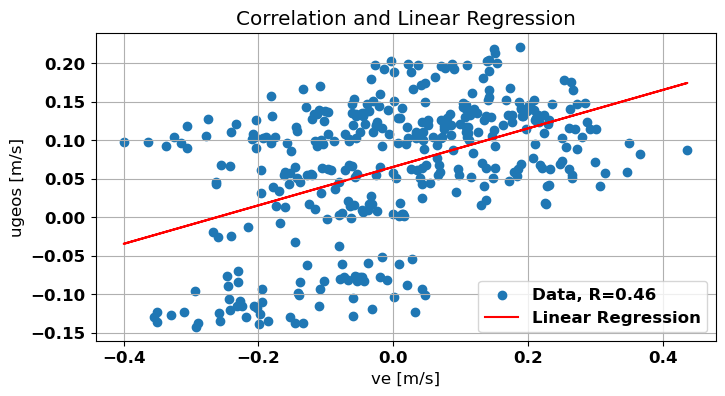

In [66]:
# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.46. 
# This means that there is a positive and moderate relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
correlation, p_value = pearsonr(bouees_courant_u, satellitaires_courant_1)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,satellitaires_courant_1)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,satellitaires_courant_1, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve [m/s]')
plt.ylabel('ugeos [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig11 mode.png")
# Show plot
plt.show()

## Using Time Series

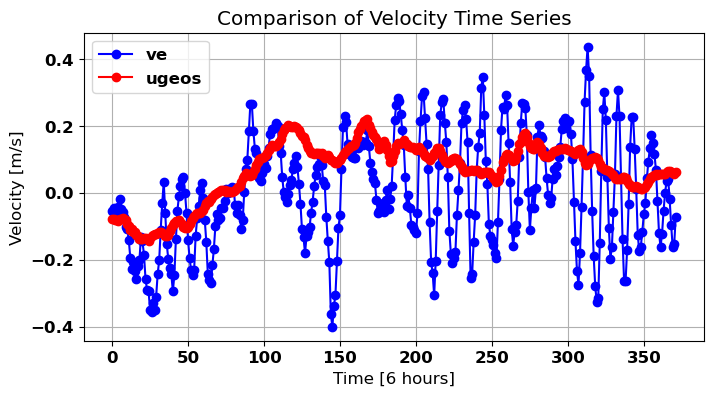

In [67]:
 # Plot time series
plt.figure(figsize=(8, 4))
plt.plot(bouees_courant_u, color='Blue', marker='o', linestyle='-',label='ve')
plt.plot(satellitaires_courant_1, color='RED', marker='o', linestyle='-', label='ugeos')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time [6 hours]')
plt.ylabel('Velocity [m/s]')
plt.grid(True)
plt.legend()

# save graphe
plt.savefig("fig12 mode.png")
# Show plot
plt.show()

## Comparison between vn and vgosa

## Using Regression and Correlation

Corrélation de Pearson: 0.6054904919966493
Valeur de p (p-value): 1.3851874804453358e-38


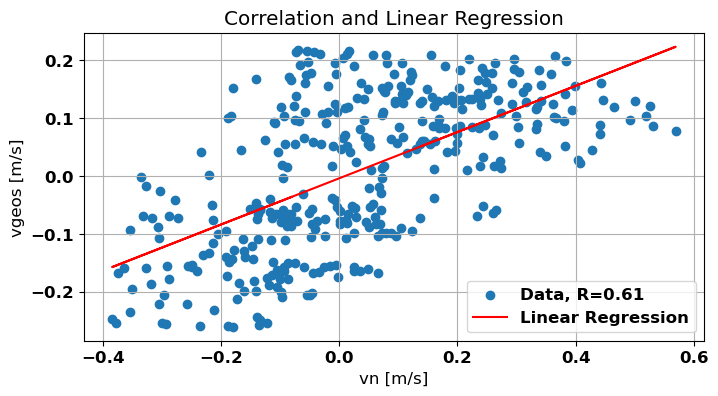

In [68]:
# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.61. 
    # This means that there is a positive and moderate relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
correlation, p_value = pearsonr(bouees_courant_v, satellitaires_courant_2)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,satellitaires_courant_2)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,satellitaires_courant_2, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn [m/s]')
plt.ylabel('vgeos [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig13 mode.png")
# Show plot
plt.show()

## Using Time Series

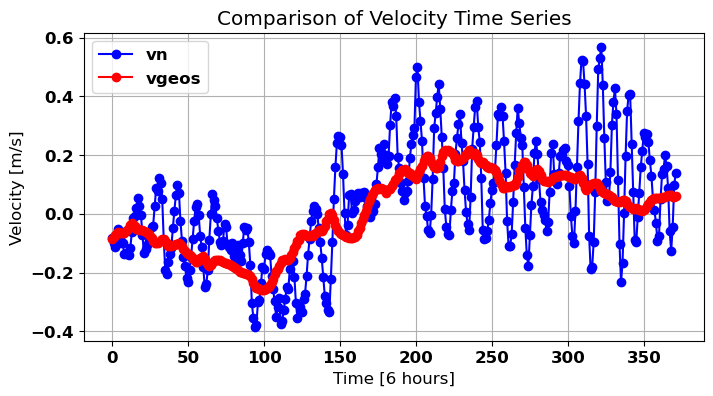

In [69]:
 # Plot time series
plt.figure(figsize=(8, 4))
plt.plot(bouees_courant_v, color='Blue', marker='o', linestyle='-',label='vn')
plt.plot(satellitaires_courant_2, color='RED', marker='o', linestyle='-', label='vgeos')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time [6 hours]')
plt.ylabel('Velocity [m/s]')
plt.grid(True)
plt.legend()

# save graphe
plt.savefig("fig14 mode.png")
# Show plot
plt.show()

# Application of a linear Hanning filter at a 24-hour resolution.

## Case of ve

In [70]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['ve'])   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
ve_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_32616\1390957898.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


## Case of vn

In [71]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['vn'])   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
vn_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_32616\2578851579.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


## Comparison between (ve_filter_Han and ugeos) and (vn_filter_Han and vgeos) 

## Using Regression and Correlation

## Case of ve_filter_Han and ugeos

Corrélation de Pearson: 0.8006580546786628
Valeur de p (p-value): 2.4773441091516694e-84


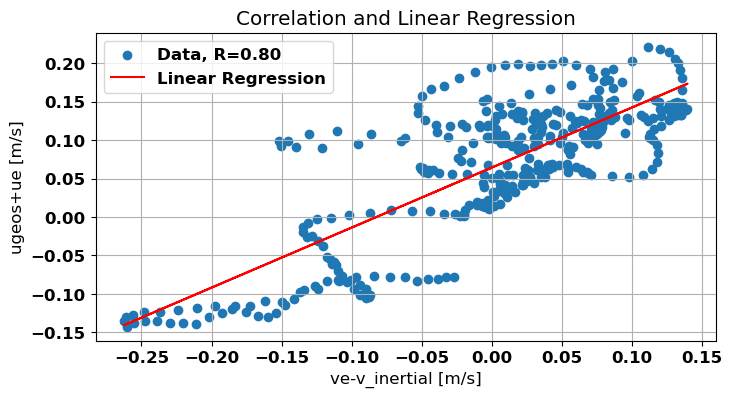

In [72]:
# According to the following, we can simply note that the correlation between "ve_filter" and "ugeos" is 0.80. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = ve_filter_Han
correlation, p_value = pearsonr(satellitaires_courant_1,bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,satellitaires_courant_1)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,satellitaires_courant_1, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve-v_inertial [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig15 mode.png")
# Show plot
plt.show()

## Case of vn_filter_Han and v_total

Corrélation de Pearson: 0.848208383405489
Valeur de p (p-value): 3.7012867712218534e-104


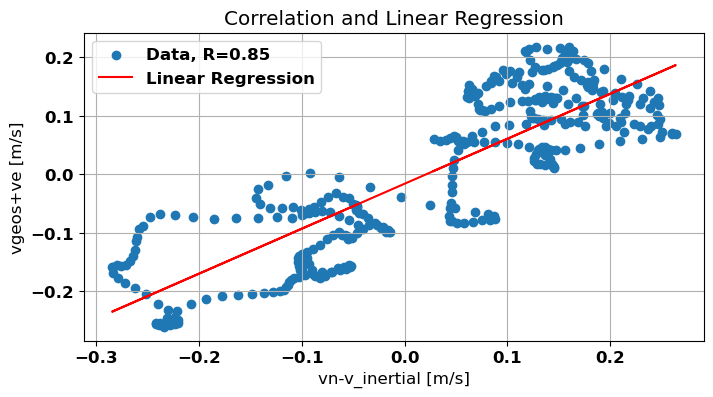

In [73]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + ve" is 0.85. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = vn_filter_Han
correlation, p_value = pearsonr(satellitaires_courant_2,bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,satellitaires_courant_2)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,satellitaires_courant_2, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn-v_inertial [m/s]')
plt.ylabel('vgeos+ve [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig16 mode.png")
# Show plot
plt.show()

## Conclusion
 - Moderate relationship between the variables ugeos (CMEMS Current) and ve (Drifter Current).
 - Moderate relationship  between vgeos (CMEMS Current) and vn (Drifter Current).
 - Zonal component dominated by the meridional component.
 - Current dominated by the inertial component compared to the Ekman component.
 - Altimetric current measurements are better and can be improved by considering certain components, notably Ekman and inertial components.